<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Importing Libraries</p> -->
# Importing Libraries

In [3]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Loading Data</p> -->
# Loading Data

In [4]:
df=pd.read_csv("/kaggle/input/gia-smp-va-smpcap-2021-csv/Gia SMP va SMPcap 2021(Gia thi truong SMP).csv", encoding='latin1', sep=';' )

<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Confusion Matrix</p>
 -->
# Let's Look at correlation Heat Map

<AxesSubplot:>

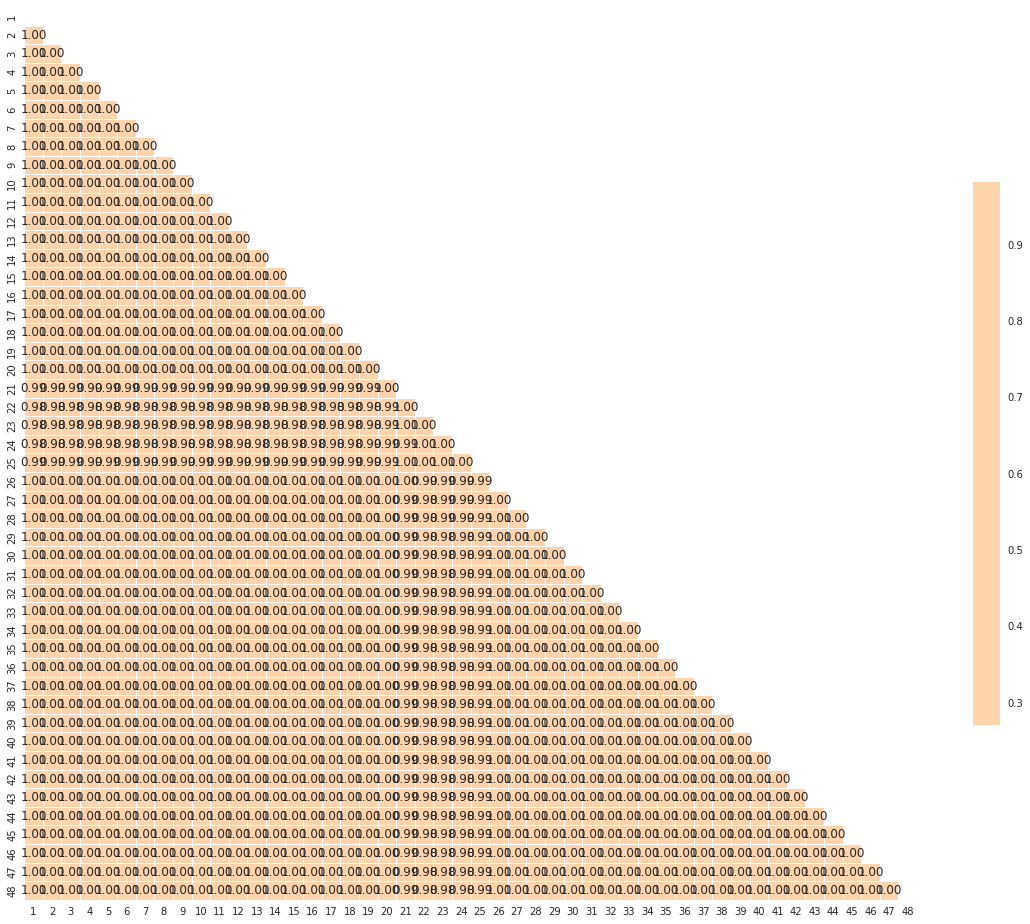

In [5]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True,fmt='.2f')

<!-- [AmbrosM](https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis) suggested some features are just not as useful as others.
> I'll be using all the integer features i.e from **(f_07, ... ,f_13)** & continuos features **(f_22 ,... ,f_28)**. -->

# Feature Selection
> This features are most important features, take a look in my other [kernel](https://www.kaggle.com/code/ashaykatrojwar/feature-selection-eda) to know more about `feature selection`.

In [6]:
feats= ['12']

<!-- # <p style="background-color:#FF7F50;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Scaling Data Data</p> -->
# Preprocessing Data 
> `Power Transformer` makes distribution more gaussian and is most appropriate for this competition.

In [7]:
# transformer = PowerTransformer()
# X=transformer.fit_transform(df[feats])
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]).reshape(-1,1))

# Elbow Method to determine optimum number of clusters to be formed:
> `3 clusters` gives the best results on leaderboard.

Elbow Method to determine the number of clusters to be formed:


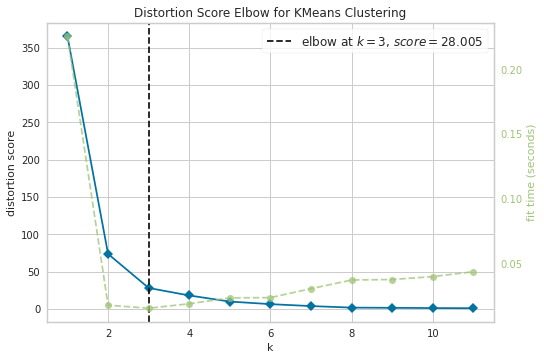

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(1,12))
Elbow_M.fit(X)
Elbow_M.show()

# Bayesian Gaussian Mixture 

In [9]:
BGM = BayesianGaussianMixture(n_components=3,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

# Creating a classifier
> Training a LGBM model from the clusters predicted from Bayessian Gaussian Mixture

In [10]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(3)]]=pp # creating new dataframe columns of probabilites
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(3):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [110]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':3}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.000154127
[400]	valid_0's multi_logloss: 0.000153877
[200]	valid_0's multi_logloss: 0.000220055
[400]	valid_0's multi_logloss: 0.000219739
[200]	valid_0's multi_logloss: 0.000147822
[400]	valid_0's multi_logloss: 0.000147526
[200]	valid_0's multi_logloss: 0.000157126
[400]	valid_0's multi_logloss: 0.000156595
[200]	valid_0's multi_logloss: 0.000151766
[400]	valid_0's multi_logloss: 0.000151346
[200]	valid_0's multi_logloss: 0.00015735
[400]	valid_0's multi_logloss: 0.000157022
[200]	valid_0's multi_logloss: 0.000153243
[400]	valid_0's multi_logloss: 0.000152818
[200]	valid_0's multi_logloss: 6.87786e-06
[400]	valid_0's multi_logloss: 6.81212e-06
[600]	valid_0's multi_logloss: 6.7634e-06
[800]	valid_0's multi_logloss: 6.72733e-06
[1000]	valid_0's multi_logloss: 6.69957e-06
[1200]	valid_0's multi_logloss: 6.67758e-06
[1400]	valid_0's multi_logloss: 6.65973e-06
[1600]	valid_0's multi_logloss: 6.64496e-06
[1800]	valid_0's multi_logloss: 6.63254e-06
[2000]	v

In [111]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [113]:
labels=np.argmax(lgb_preds,axis=1)


# Ploting the count plot for cluster distribution

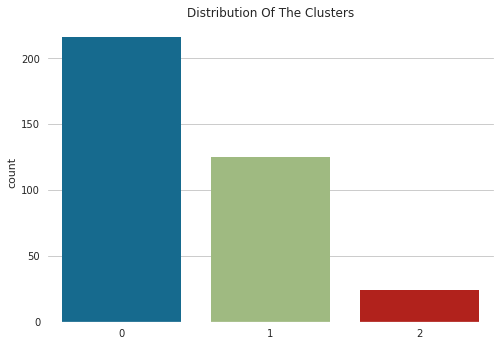

In [114]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

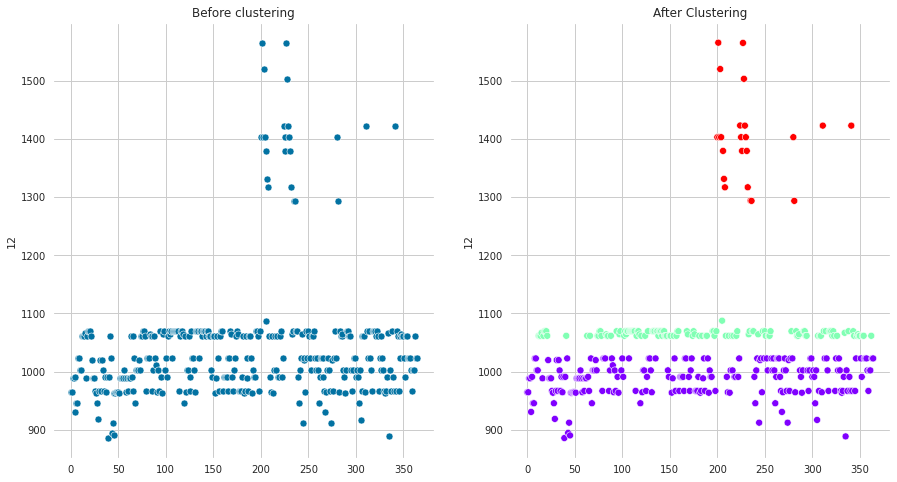

In [46]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, label="bla")
sns.scatterplot(x=df.index, y=feats[0], data=df, marker='o', ax=ax)
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, label="bla")
sns.scatterplot(x=df.index, y=feats[0], data=df, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

### Models

In [23]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [24]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [98]:
test_size = 30

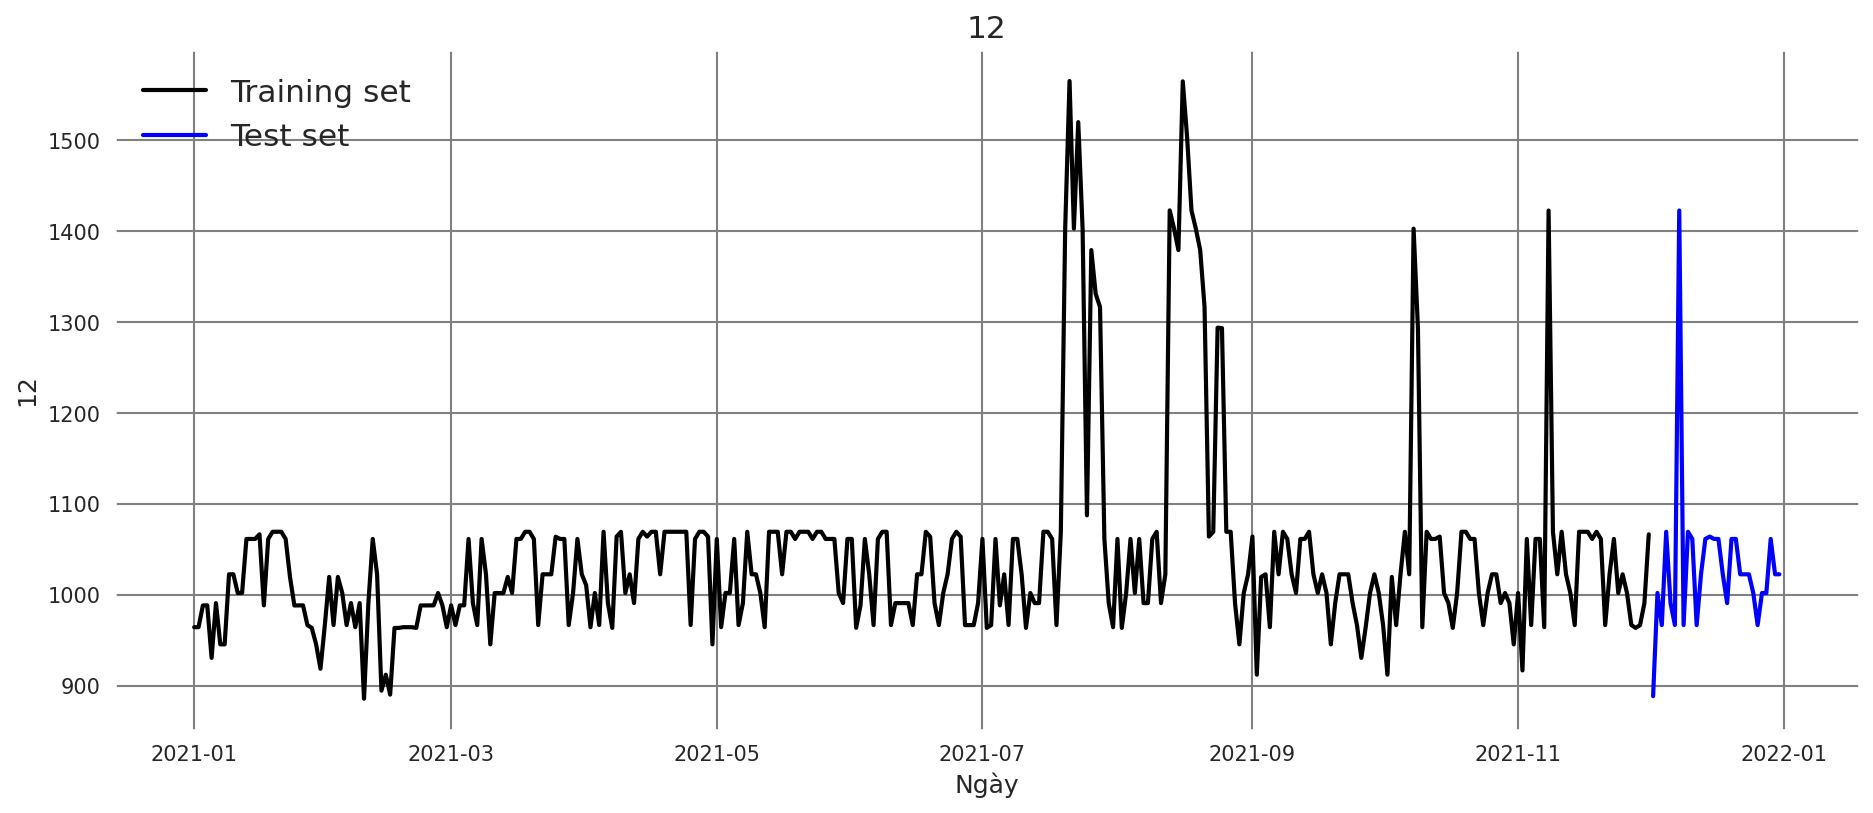

In [99]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['12'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['12'][-test_size:], color='blue', lw=2)
plt.title('12', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('12', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='grey')
plt.show()

In [100]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['12'].values.reshape(-1,1))

MinMaxScaler()

In [101]:
window_size = 90
train_data = df['12'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [102]:
test_data = df['12'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [103]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [104]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

### LSTM Model

In [105]:
from tensorflow.keras import Sequential
def define_model():
    model = Sequential()
    model.add(LSTM(100, activation='tanh', return_sequences = False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [106]:
model = define_model()
history = model.fit(X_train, y_train, epochs=10, batch_size=20, validation_split=0.1, verbose=1)

Epoch 1/10
11/11 [==============================] - 2s 61ms/step - loss: 0.0465 - val_loss: 0.0209
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0191
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0222 - val_loss: 0.0182
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0181
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0199 - val_loss: 0.0182
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0185
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0177 - val_loss: 0.0187
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.0195
Epoch 10/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0169 - val_loss: 0.0193


In [107]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 18ms/step - loss: 0.0173


In [108]:
from sklearn.metrics import accuracy_score,r2_score
r2 = r2_score(y_test, y_pred)
print(r2)

-0.1334649154429397


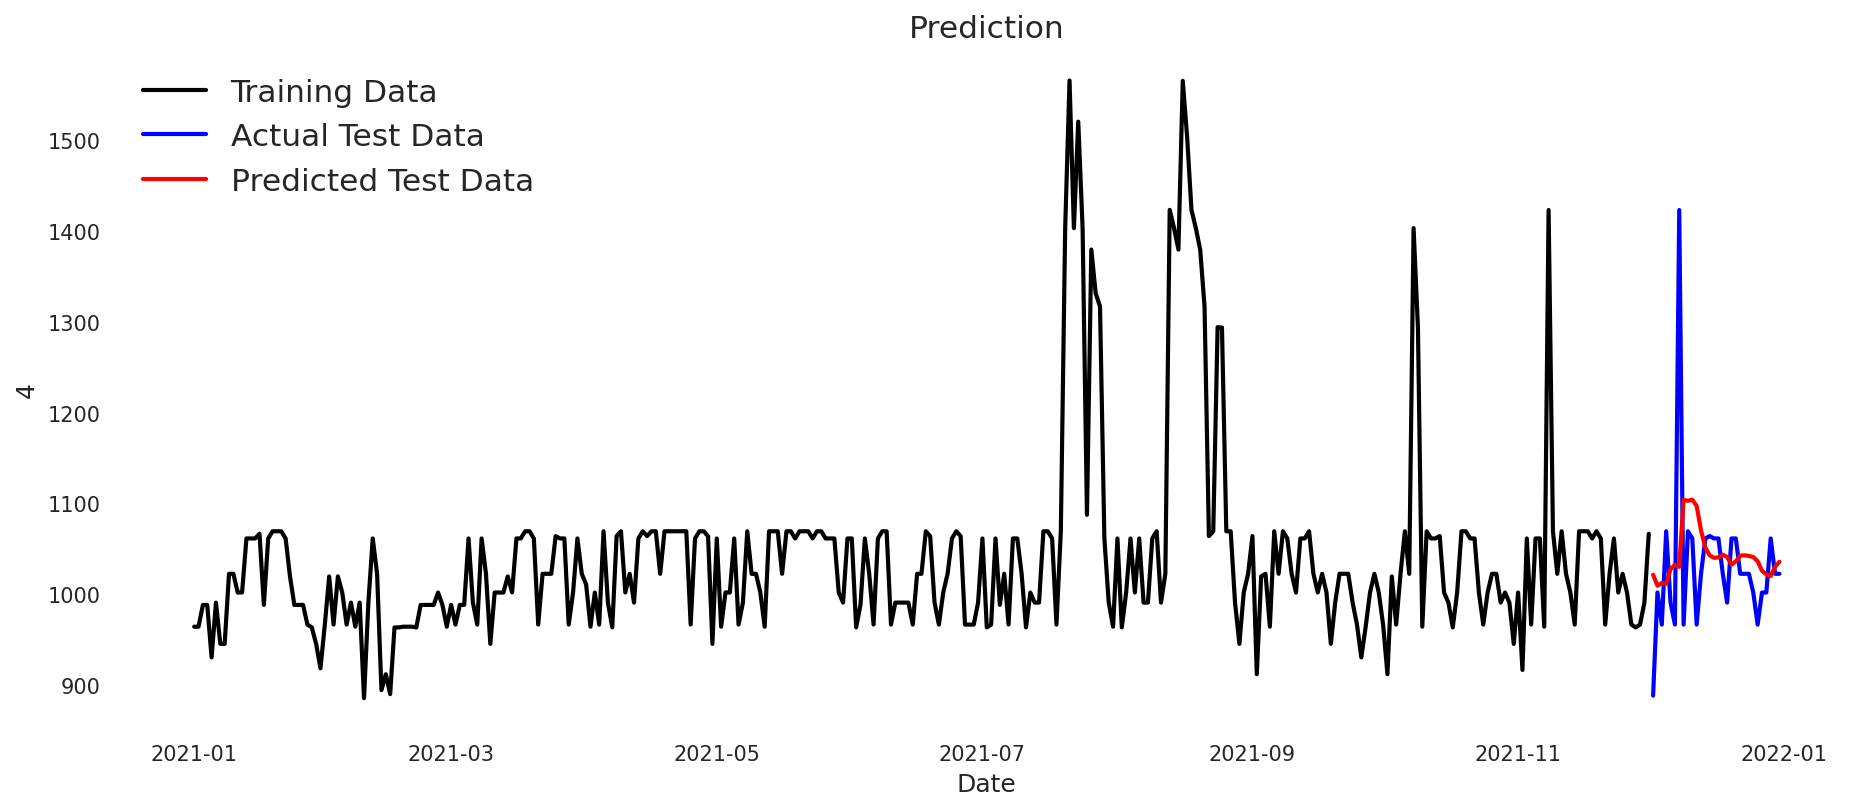

In [109]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)
plt.figure(figsize=(15, 6), dpi=150)
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()